# <font color='orange'>0. IMPORTAÇÃO</font>

## <font color='green'>0.1. Bibliotecas</font>

In [1]:
import numpy        as np
import pandas       as pd
import seaborn      as sns

from matplotlib     import pyplot as plt

from sklearn import cluster as c
from sklearn import metrics as m

from plotly import express as px

## <font color='green'>0.2. Funções de Ajuda</font>

In [2]:
def jupyter_settings():
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    plt.style.use( 'bmh' )

    pd.options.display.max_columns = None

jupyter_settings()

## <font color='green'>0.3. Carregando os Dados</font>

In [3]:
# Carregando dados
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')

# Drop extra colums
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

# <font color='orange'>1. DESCRIÇÃO DOS DADOS</font>

In [4]:
df1 = df_raw.copy()

## <font color='green'>1.1. Renomeando colunas</font>

In [5]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## <font color='green'>1.2. Dimensão dos dados</font>

In [6]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 541909
Número de colunas: 8


## <font color='green'>1.3. Tipo dos dados</font>

In [7]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## <font color='green'>1.4. Verificando NA</font>

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## <font color='green'>1.5. Tratando NA</font>

In [10]:
# Removendo NA
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Dados removidos: {:.2f}%'.format( 100 - (df1.shape[0] / df_raw.shape[0]) * 100 ) )

Dados removidos: 24.93%


In [11]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## <font color='green'>1.6. Alterando tipo dos dados</font>

In [12]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [13]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [14]:
# invoicce date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'] )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )

In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## <font color='green'>1.7. Estatística descritiva</font>

# <font color='orange'>2. FEATURE ENGINEERING</font>

In [16]:
df2 = df1.copy()

## <font color='green'>2.1. Criação de Feature</font>

In [17]:
# data reference
df_ref = df2[['customer_id']].drop_duplicates( ignore_index=True )

# Gross Revenue (faturamento ) - quantity * price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )

# Recency - Last day purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_day'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_day']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

# Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().rename(columns={'invoice_no': 'invoice_size'})
df_ref = pd.merge( df_ref, df_freq, how='left', on='customer_id' )

# <font color='orange'>3. FITLRAGEM DE VARIÁVEIS</font>

In [18]:
df3 = df_ref.copy()

# <font color='orange'>4. ANÁLISE EXPLORATÓRIA DOS DADOS</font>

In [19]:
df4 = df3.copy()

# <font color='orange'>5. PREPARAÇÃO DOS DADOS</font>

In [20]:
df5 = df4.copy()

# <font color='orange'>6. SELEÇÃO DE VARIÁVEIS</font>

In [21]:
df6 = df5.copy()

# <font color='orange'>7. HYPERPARAMETER FINE-TUNNING</font>

In [22]:
X = df6.drop( columns=['customer_id'] )

In [23]:
clusters = [2, 3, 4, 5, 6]

## <font color='green'>7.1. Within-Cluster Sum of Square ( WSS )</font>

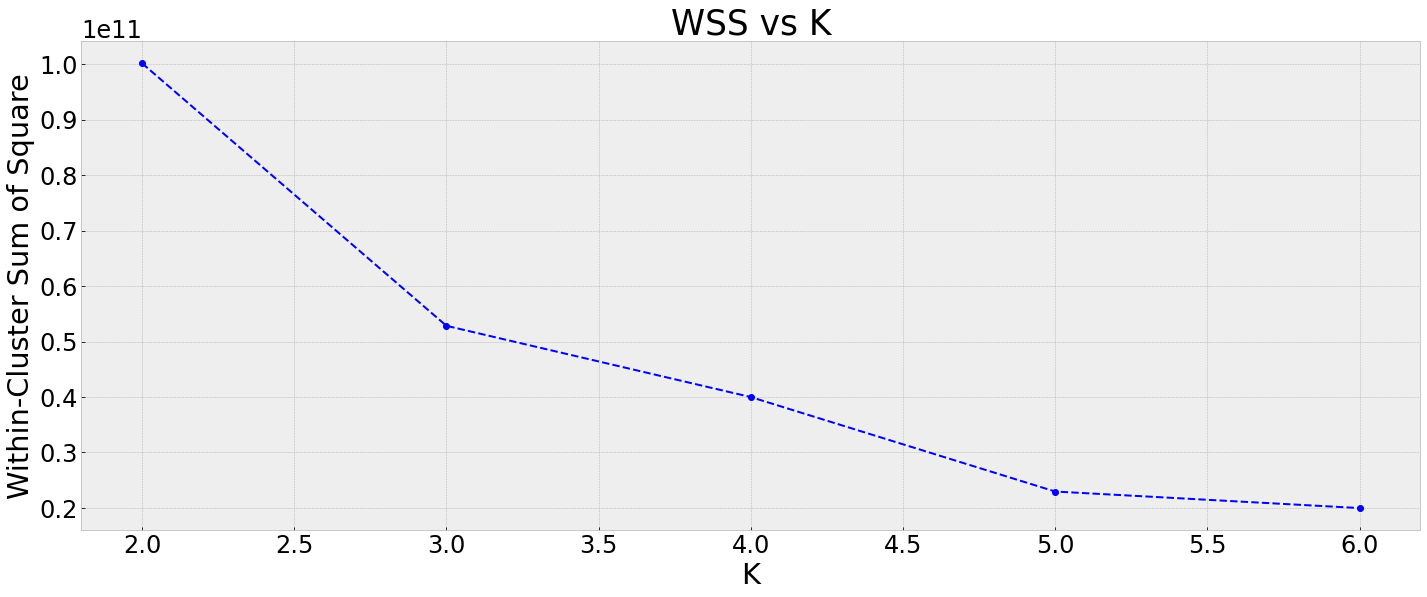

In [24]:
wss = []

for k in clusters:
    # model definition
    kmeans = c.KMeans ( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

    # model training
    kmeans.fit( X )

    # validation
    wss.append( kmeans.inertia_ )

# plot WSS - Elbow Method
plt.plot( clusters, wss, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' )
plt.ylabel( 'Within-Cluster Sum of Square' )
plt.title( 'WSS vs K' );

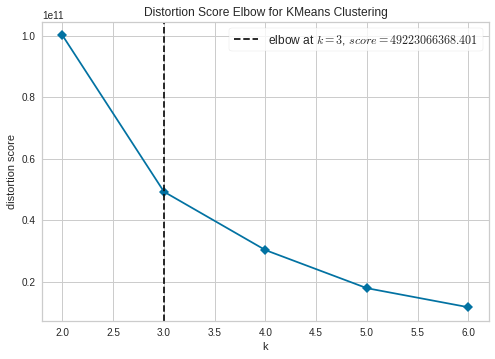

In [25]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit( X )
kmeans.show();

## <font color='green'>7.2. Sillhouette Score</font>

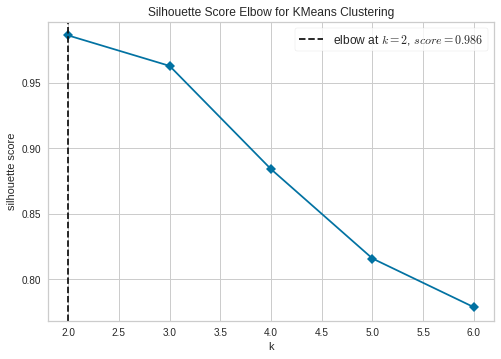

In [26]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show();

## <font color='green'>7.3. Sillhouette Analysis</font>

# <font color='orange'>8. TREINAMENTO DO MODELO</font>

## <font color='green'>8.1. K-Means</font>

In [27]:
# model definition
k = 3
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

## <font color='green'>8.2. Cluster Validation</font>

In [28]:
# WSS ( Within-cluster sum of square )
print( 'WSS value: {}'.format( kmeans.inertia_ ))

# SS ( Silhouette Score)
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 52830442008.00695
SS value: 0.9494677566681542


# <font color='orange'>9. ANÁLISE DO CLUSTER</font>

In [29]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_day,invoice_size,cluster
0,17850,5288.63,302,35,0
1,13047,3079.10,31,18,0
2,12583,7187.34,2,18,0
3,13748,948.25,95,5,0
4,15100,635.10,330,6,0


## <font color='green'>9.1. Visualization Inspection</font>

In [30]:
fig = px.scatter_3d( df9, x='recency_day', y='invoice_size', z='gross_revenue', color='cluster')
fig.show()

## <font color='green'>9.2. Cluster Profile</font>

In [31]:
df9.head()

,customer_id,gross_revenue,recency_day,invoice_size,cluster
0,17850,5288.63,302,35,0
1,13047,3079.10,31,18,0
2,12583,7187.34,2,18,0
3,13748,948.25,95,5,0
4,15100,635.10,330,6,0


In [40]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100 * ( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_day = df9[['recency_day', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_day, how='inner', on='cluster' )


# Avg invoice_no
df_avg_invoice_size = df9[['invoice_size', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_size, how='inner', on='cluster' )

# df_cluster['teste'] = df_cluster['customer_id'] * df_cluster['gross_revenue']
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_day,invoice_size
0,0,4335,99.153705,1372.577826,92.257901,4.614533
1,1,6,0.137237,182181.981667,7.166667,89.000000
2,2,31,0.709058,40543.517742,13.290323,53.290323


### Cluster 01: ( Candidato à Insider )
- Número de customers: 6 ( 0.14% dos customers )
- Recência em média: 7 dias
- Compras em média: 89 compras
- Receita em média: $182.182,00 dólares
/
### Cluster 02:
- Número de customers: 31 ( 0.71% dos customers )
- Recência em média: 14 dias 
- Compras em média: 53 compras
- Receita em média: $40.542,52 dólares

### Cluster 03:
- Número de customers: 4.335 ( 99% dos customers )
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: $1.372,57 dólares

# <font color='orange'>10. DEPLOY DO MODELO EM PRODUÇÃO</font>